In [50]:
using LinearAlgebra
using Plots
using MultivariateStats#, StatsPlots
using Distributions
using DelimitedFiles
using DataFrames
using CSV
using ProgressMeter
using Profile

# Unscented Kalman Filtering on a Kinematic Bicycle

## Helper Functions

In [51]:
# f, Kinematic bicycle with teleporting steering
function dynamics(x, u, params)
    v, l = params
    px, py, θ = x
    δ = u[1]
    ẋ = [v*cos(θ);
         v*sin(θ);
         v*tan(δ) / l]
    return ẋ
end

dynamics (generic function with 1 method)

In [52]:
# Approximately integrate dynamics over a timestep dt to get a discrete update function
function rk4(xₖ, uₖ, params, dt)
    k1 = dynamics(xₖ, uₖ, params)
    k2 = dynamics(xₖ + k1*dt/2, uₖ, params)
    k3 = dynamics(xₖ + k2*dt/2, uₖ, params)
    k4 = dynamics(xₖ + k3*dt, uₖ, params)

    xₖ₊₁ = xₖ + dt * (k1 + 2k2 + 2k3 + k4) / 6
    return xₖ₊₁
end

rk4 (generic function with 1 method)

In [53]:
# Given a mean and covariance in N-dimensional space, generate 2N+1 weighted points
# with the given weighted mean and weighted covariance
function generate_sigma_points(x̂, Σ)
    Nx = length(x̂)
    A = sqrt(Σ)
    σ = [zeros(Nx) for j in 1:(2Nx+1)]
    W = zeros(2Nx+1)
    W[1] = 1/3

    σ[1] .= x̂

     for j in 1:Nx
        σ[1+j] .= @. x̂ + √(Nx / (1 - W[1])) * A[:,j] 
     end
 
     for j in 1:Nx
        σ[1+Nx+j] .= @. x̂ - √(Nx / (1 - W[1])) * A[:,j] 
     end
 
    W[2:end] .= (1- W[1])/(2Nx)
    
    return σ, W
end

generate_sigma_points (generic function with 1 method)

In [54]:
# maps vector in state space to vector in measurement space
# g, "GPS" measurement of positions
function measurement(x)
    y = x[1:2]
    return y
end

measurement (generic function with 1 method)

In [55]:
function accuracy_to_gps_noise!(R, accuracy)
  accuracy /= 1000.0
  σ = (accuracy / (0.848867684498)) * (accuracy / (0.848867684498))
  R .= [σ 0.0;
    0.0 σ]
end

accuracy_to_gps_noise! (generic function with 1 method)

## Predict and Update

In [56]:
# Given a state estimate and covariance, apply nonlinear dynamics over dt to sigma points
# and calculate a new state estimate and covariance
function ukf_predict(x̂ₖ, Σₖ, Q, uₖ, dt, params)
    Nx = length(x̂ₖ)
    σ, W = generate_sigma_points(x̂ₖ, Σₖ)

    for k in 1:lastindex(σ)
        σ[k] .= rk4(σ[k], uₖ, params, dt)
    end 

    x̂ₖ₊₁ = zeros(Nx)
    Σₖ₊₁ = zeros(Nx, Nx)

    for k in 1:lastindex(σ)
        x̂ₖ₊₁ .+= W[k].* σ[k]
    end
    for k in 1:lastindex(σ)
        Σₖ₊₁ .+= W[k].* ((σ[k] - x̂ₖ₊₁) * (σ[k] - x̂ₖ₊₁)')
    end

    # Σₖ₊₁ .+= Q * dt

    return x̂ₖ₊₁, Σₖ₊₁
end

ukf_predict (generic function with 1 method)

In [57]:
# Given a state estimate, covariance of the state estimate, measurement and covariance of the measurement,
# apply the measurement function to sigma points,
# calculate the mean and covariance in measurement space, then use this to calculate the Kalman gain, 
# then use the gain and measurement to calculate the updated state estimate and covariance.
function ukf_update(x̂, Σ, y, R)
    Nx = length(x̂)
    Ny = length(y)
    σ, W = generate_sigma_points(x̂, Σ)
    z = [zeros(Ny) for _ in σ]

    for j in 1:lastindex(σ)
        z[j] = measurement(σ[j])
    end 

    ẑ = zeros(Ny)
    S = zeros(Ny, Ny)
    Cxz = zeros(Nx, Ny)

    for k in 1:lastindex(z)
        ẑ .+= W[k].* z[k]
    end
    for k in 1:lastindex(z)
        S .+= W[k].* (z[k] - ẑ) * (z[k] - ẑ)'
        Cxz .+= W[k] .* (σ[k] - x̂) * (z[k] - ẑ)'
    end
    S .+= R

    K = Cxz * inv(S)

    x̂ₖ₊₁ = x̂ + K * (y - ẑ)
    Σₖ₊₁ = Σ - K * S * K'
    return x̂ₖ₊₁, Σₖ₊₁
end

ukf_update (generic function with 1 method)

# Testing
using the filter on a simulated scenario

## Defining properties of the scenario
system parameters and covariances

In [58]:
# System parameters

l = 1.0 # Wheelbase, (m)
v = 0.0 # Velocity, (m/s)
params = v, l

(0.0, 1.0)

In [59]:
# Covariances. Remember, these are in squared units. To get an idea of the 
# corresponding 95% confidence interval, take the square root and multiply by ~2.

# Σ0 = diagm(ones(3)) # Initial estimate covariance for the filter
# Σ0 = diagm([1.5, 1.5, 1.5]) 
# Σ0 = diagm([3, 3, 3]) 
# Σ0 = zeros(3)
Σ0 = diagm([1e-4; 1e-4; 1e-6]) 

R = diagm([1e-2, 1e-2]) # Sensor covariances (m^2, m^2)
Q = diagm([1e-4; 1e-4; 3e-4]) # Process covariances (m^2, m^2, rad^2) 
                              # ^ the process covariances are timestep size dependent

3×3 Matrix{Float64}:
 0.0001  0.0     0.0
 0.0     0.0001  0.0
 0.0     0.0     0.0003

## Loading Measurement and Input Data
gps, encoder, steering

In [60]:
run_name = "log130"
gps_df      = DataFrame(CSV.File("nand-logs/$run_name-gps.csv"))
encoder_df  = DataFrame(CSV.File("nand-logs/$run_name-encoder.csv"))
steering_df = DataFrame(CSV.File("nand-logs/$run_name-steering.csv"))
filter_df = DataFrame(CSV.File("nand-logs/$run_name-filter.csv"))
covar_df = DataFrame(CSV.File("nand-logs/$run_name-covar.csv"))


gps_df[!, "timestamp"] = gps_df[!, "timestamp"] ./ 1000.0           
encoder_df[!, "timestamp"] = encoder_df[!, "timestamp"] ./ 1000.0   
steering_df[!, "timestamp"] = steering_df[!, "timestamp"] ./ 1000.0 
filter_df[!, "timestamp"] = filter_df[!, "timestamp"] ./ 1000.0 
covar_df[!, "timestamp"] = covar_df[!, "timestamp"] ./ 1000.0 



12002-element Vector{Float64}:
 11.025
 11.027
 11.03
 11.033
 11.037
 11.04
 11.043
 11.046
 11.051
 11.054
  ⋮
 98.381
 98.392
 98.398
 98.405
 98.411
 98.419
 98.423
 98.426
 98.435

In [61]:
gps_df

Row,timestamp,pos_x,pos_y,accuracy
,Float64,Float64,Float64,Float64
1,11.234,4.47741e6,5.89611e5,14.1
2,11.337,4.47741e6,5.89611e5,14.1
3,11.438,4.47741e6,5.89611e5,14.1
4,11.542,4.47741e6,5.89611e5,14.1
5,11.645,4.47741e6,5.89611e5,14.1
6,11.751,4.47741e6,5.89611e5,14.1
7,11.853,4.47741e6,5.89611e5,14.1
8,11.958,4.47741e6,5.89611e5,14.1
9,12.059,4.47741e6,5.89611e5,14.1


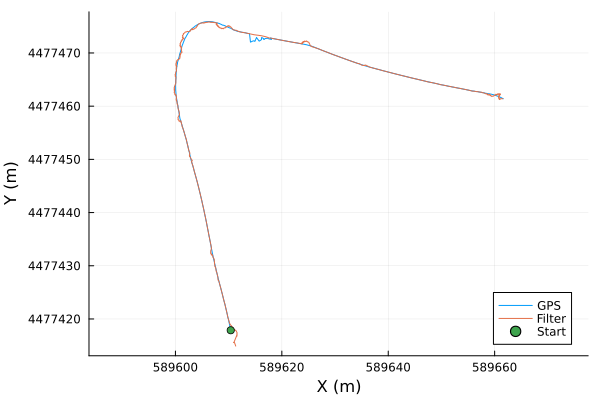

In [62]:
# Plot filtered and gps result from data
init_idx = findfirst(!isequal(0.0), filter_df[:, "pos_x"])+1
plot(aspect_ratio=:equal, xlabel="X (m)", ylabel="Y (m)")
plot!(gps_df[init_idx:end, "pos_y"], gps_df[init_idx:end, "pos_x"], label="GPS")
plot!(filter_df[init_idx:end, "pos_y"], filter_df[init_idx:end, "pos_x"], label="Filter")
scatter!(gps_df[init_idx:init_idx, "pos_y"], gps_df[init_idx:init_idx, "pos_x"], label="Start")

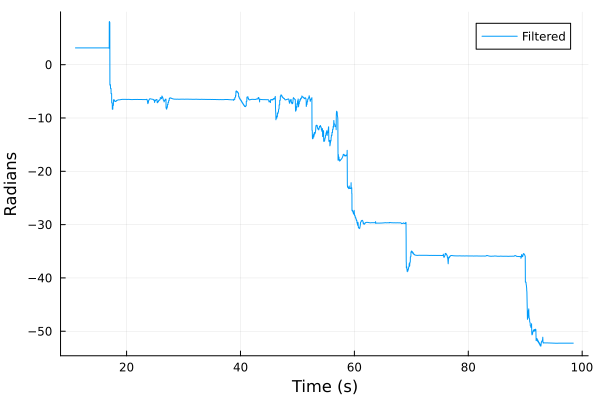

In [63]:
plot(filter_df[:, "timestamp"], filter_df[:, "heading"], ylabel="Radians", xlabel="Time (s)", label="Filtered")

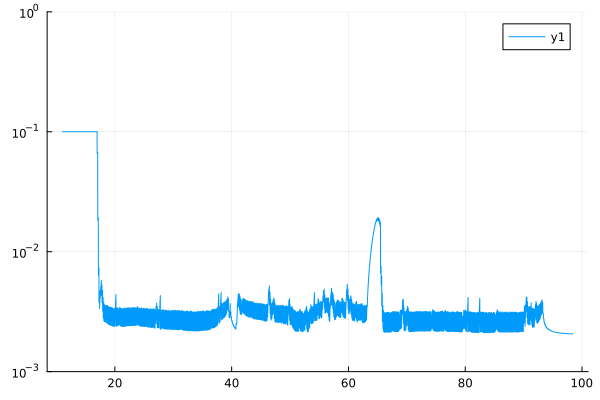

In [64]:
plot(covar_df[:, "timestamp"], covar_df[:, "c9"],  yscale=:log10, ylim=(1e-3, 1))

## Running the UKF

In [65]:
# Simulate a non-deterministic process with process covariance Q and measurement covariance R,
# and with an Unscented Kalman Filter applied
function simulate_uk_filter(Q, R, gps_df, encoder_df, steering_df, l)
  gps_row = 1
  encoder_row = 1
  steering_row = 1

  gps_time = gps_df[!, "timestamp"]
  encoder_time = encoder_df[!, "timestamp"]
  steering_time = steering_df[!, "timestamp"]
  gps_accuracy = gps_df[!, "accuracy"]
  gps_pos_x = gps_df[!, "pos_x"]
  gps_pos_y = gps_df[!, "pos_y"]
  steering = deg2rad.(steering_df[:, "steering"])
  speed = encoder_df[!, "speed"]

  x̂ = [gps_df[1, "pos_x"]; gps_df[1, "pos_y"]; 0.0]
  Σ = diagm([1.0; 1.0; 1.0])
  Nk = size(gps_df, 1) + size(encoder_df, 1) + size(steering_df, 1)
  k = 1

  Xhat = [zeros(3) for k in 1:Nk]
  Sigma = [zeros(3, 3) for k in 1:Nk]

  v = 0.0

  last_predict_timestamp = min(gps_time[1], encoder_time[1], steering_time[1])

  while (gps_row <= size(gps_df, 1) && encoder_row <= size(encoder_df, 1) && steering_row <= size(steering_df, 1)) && gps_row < 1000

    if (last_predict_timestamp > gps_time[gps_row] && last_predict_timestamp > encoder_time[encoder_row] && last_predict_timestamp > steering_time[steering_row])
      continue
    end

    if (gps_time[gps_row] < encoder_time[encoder_row] && gps_time[gps_row] < steering_time[steering_row])
      # gps is the next timestamp
      # set the new gps noise
      # predict using most recent steering and velocity
      # then update using the current gps noise
      dt = gps_time[gps_row] - last_predict_timestamp

      accuracy_to_gps_noise!(R, gps_accuracy[gps_row])

      x̂, Σ = ukf_predict(x̂, Σ, Q, steering[steering_row], dt, (v, l))

      x̂, Σ = ukf_update(x̂, Σ, [gps_pos_x[gps_row]; gps_pos_y[gps_row]], R)

      last_predict_timestamp = gps_time[gps_row]
      gps_row += 1
    elseif (encoder_time[encoder_row] < steering_time[steering_row])
      # encoder is the next timestamp
      # set the new speed stored by instance of UKF
      # predict using most recent steering and new speed
      dt = encoder_time[encoder_row] - last_predict_timestamp

      v = speed[encoder_row]
      x̂, Σ = ukf_predict(x̂, Σ, Q, steering[steering_row], dt, (v, l))

      last_predict_timestamp = encoder_time[encoder_row]
      encoder_row += 1
    else
      # steering is the next timestamp
      # predict using this new steering
      dt = steering_time[steering_row] - last_predict_timestamp

      x̂, Σ = ukf_predict(x̂, Σ, Q, steering[steering_row], dt, (v, l))

      last_predict_timestamp = steering_time[steering_row]
      steering_row += 1
    end


    Xhat[k] .= x̂
    Sigma[k] .= Σ
    k += 1
  end

  return Xhat, Sigma
end

simulate_uk_filter (generic function with 1 method)

In [66]:
@time Xhat, Sigma = simulate_uk_filter(Q, R, gps_df, encoder_df, steering_df, l)

  0.577754 seconds (2.64 M allocations: 186.191 MiB, 6.72% gc time, 78.91% compilation time)


([[4.477414910032e6, 589611.332367, 0.0], [4.477414910032e6, 589611.332367, 0.0], [4.477414910032e6, 589611.332367, 0.0], [4.477414910123302e6, 589611.3323669981, -4.098047793318904e-5], [4.477414910168953e6, 589611.3323669957, -6.147071689976968e-5], [4.477414910294492e6, 589611.3323669854, -0.0001046141586556748], [4.477414910442857e6, 589611.3323669675, -0.00013788236059689152], [4.477414910568397e6, 589611.3323669493, -0.00015334274999886932], [4.477414910627943e6, 589611.3323669401, -0.00015405857844649762], [4.47741491072322e6, 589611.3323669254, -0.0001552039039627584]  …  [4.477471435066288e6, 589660.9424781795, -5.983114578043857], [4.477471435068261e6, 589660.9424787896, -5.983114578043857], [4.477471435070069e6, 589660.9424793487, -5.983114578043858], [4.477471397829993e6, 589660.961261729, -5.982320833072831], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]], [[1.0000000000157723 0.0 0.0; 0.0 1.0000000000157723 0.0; 0.0 0

In [67]:
Profile.clear()
Xhat

8654-element Vector{Vector{Float64}}:
 [4.477414910032e6, 589611.332367, 0.0]
 [4.477414910032e6, 589611.332367, 0.0]
 [4.477414910032e6, 589611.332367, 0.0]
 [4.477414910123302e6, 589611.3323669981, -4.098047793318904e-5]
 [4.477414910168953e6, 589611.3323669957, -6.147071689976968e-5]
 [4.477414910294492e6, 589611.3323669854, -0.0001046141586556748]
 [4.477414910442857e6, 589611.3323669675, -0.00013788236059689152]
 [4.477414910568397e6, 589611.3323669493, -0.00015334274999886932]
 [4.477414910627943e6, 589611.3323669401, -0.00015405857844649762]
 [4.47741491072322e6, 589611.3323669254, -0.0001552039039627584]
 ⋮
 [4.477471435068261e6, 589660.9424787896, -5.983114578043857]
 [4.477471435070069e6, 589660.9424793487, -5.983114578043858]
 [4.477471397829993e6, 589660.961261729, -5.982320833072831]
 [0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0]

## Visualizations

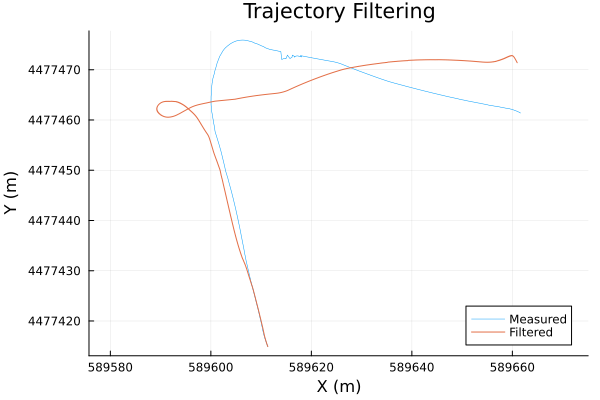

In [68]:
# Let's see how the filter does on position estimation

plot(title="Trajectory Filtering", xlabel="X (m)", ylabel="Y (m)", aspect_ratio=:equal)
plot!(gps_df[:, "pos_y"], gps_df[:, "pos_x"], label="Measured", linewidth=0.5)
plot!([x[2] for x in Xhat[1:(end-6)]], [x[1] for x in Xhat[1:(end-6)]], label="Filtered")

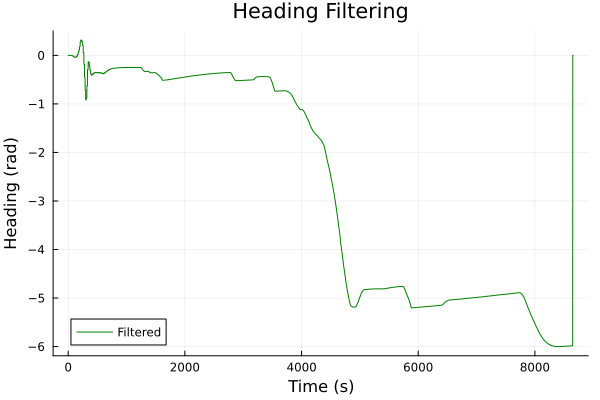

In [69]:
# Remember, we aren't measuring the heading, only a noisy position, 
# but the filter is able to use this information to converge to
# a good estimate of the heading over time.

plot(title="Heading Filtering", xlabel="Time (s)", ylabel="Heading (rad)")
# plot!(t, [x[3] for x in X], label="True")
plot!([x[3] for x in Xhat], label="Filtered", color="green")

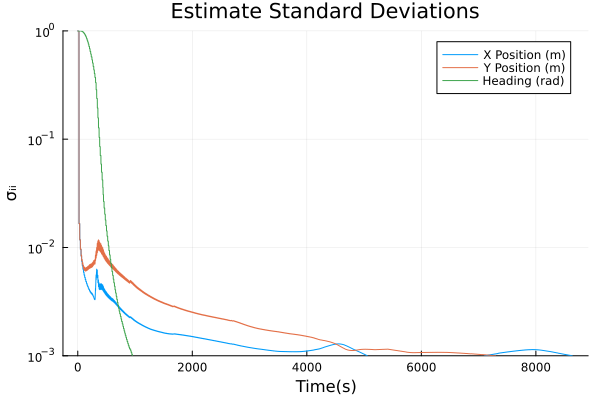

In [70]:
# And let's see how the filter's confidence in its estimate evolves over time

plot(title="Estimate Standard Deviations", xlabel="Time(s)", ylabel="σᵢᵢ", yscale=:log10, ylim=(1e-3, 1))
plot!([√(σ²[1,1]) for σ² in Sigma], label="X Position (m)")
plot!([√(σ²[2,2]) for σ² in Sigma], label="Y Position (m)")
plot!([√(σ²[3,3]) for σ² in Sigma], label="Heading (rad)")